# Dynamic Linear Model

In [16]:
import os
import math

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.contrib.tracking.extended_kalman_filter import EKFState
from pyro.contrib.tracking.distributions import EKFDistribution
from pyro.contrib.tracking.dynamic_models import NcvContinuous
from pyro.contrib.tracking.measurements import PositionMeasurement
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam
from pyro.ops.stats import quantile

from main import get_energy_data, get_weather_data
import pandas as pd
import matplotlib.pyplot as plt

pyro.set_rng_seed(20200928)
torch.manual_seed(20200101)

pd.set_option('display.max_rows', 500)



## Data

In [44]:
df = pd.read_csv("preprocessed_data/df.csv")#.iloc[:1000]
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)#'%Y-%m-%d %H:%M:%S.%f') # 2015-01-01 10:00:00+00:00
dfW = get_weather_data(df)
dfE = get_energy_data(df)

X_W = torch.from_numpy(dfW.values).float()
X_E = torch.from_numpy(dfE.values).float()

obs = torch.from_numpy(df["price actual"].values).float()

# translate to pyro forecasting language
y = obs.unsqueeze(-1)
covariates = X_E

# define constants
n, p = X_E.shape

# start, train end, test end
T0 = 0
T1 = n - n//10 # 10 % test data
T2 = n

print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)

Number of observations: 178181
Number of training observations: 160363
Number of test observations: 17818


In [7]:
# covariates = torch.cat(
#     [torch.ones(n, 1), torch.randn(n, p) * 0.1],
#     dim=-1
# )
# beta0 = torch.empty(n, 1).normal_(0, 0.1).cumsum(0)
# betas_p = torch.empty(n, p).normal_(0, 0.02).cumsum(0)
# betas = torch.cat([beta0, betas_p], dim=-1)
# y = ((covariates * betas).sum(-1) + 0.1 * torch.randn(n)).unsqueeze(-1)

# covariates.shape, X_E.shape, y.shape, obs.shape

(torch.Size([1000, 11]),
 torch.Size([1000, 10]),
 torch.Size([1000, 1]),
 torch.Size([1000]))

## Model

In [4]:
class VanillaDLM(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))

        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace
        pyro.deterministic("weight", weight)

        prediction = (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)

        self.predict(noise_dist, prediction)

## Inference

In [45]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = VanillaDLM()
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
)

INFO 	 step    0 loss = 1.21954e+11
INFO 	 step  100 loss = 14.8221
INFO 	 step  200 loss = 7.18281
INFO 	 step  300 loss = 5.2426
INFO 	 step  400 loss = 4.93827
INFO 	 step  500 loss = 4.83755
INFO 	 step  600 loss = 4.83248
INFO 	 step  700 loss = 4.3766
INFO 	 step  800 loss = 4.42503
INFO 	 step  900 loss = 4.39437


CPU times: total: 28min 23s
Wall time: 4min 45s


In [46]:
pyro.set_rng_seed(1)
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

# posterior_samples["prediction"].shape


## Analyze posterior samples

In [15]:
posterior_samples.keys()

dict_keys(['particles', 'time', 'drift_scale', 'drift_decentered', 'drift', 'weight', 'prediction', 'noise_scale', 'residual'])

In [47]:
# extract percentiles of the posterior samples
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)

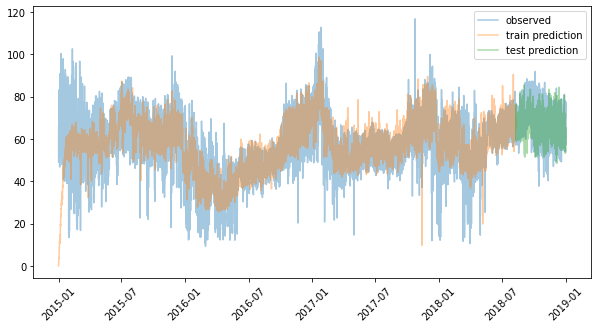

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

dates = df.time_str.values

ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()